In [18]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.animation as animation

np.random.seed(1234)

In [19]:
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.current_device())  # Should return an integer (GPU index)
print(torch.cuda.get_device_name(torch.cuda.current_device()))  # GPU name

True
0
NVIDIA GeForce GTX 1650


In [20]:
# CUDA support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f"Using device: {device}")

torch.backends.cudnn.benchmark = True

Using device: cuda


In [21]:
class DNN(nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        modules = []
        for i in range(len(layers) - 2):  # Exclude last layer for activation
            modules.append(nn.Linear(layers[i], layers[i+1]))
            modules.append(nn.Tanh())
        modules.append(nn.Linear(layers[-2], layers[-1]))  # Last layer (no activation)
        self.network = nn.Sequential(*modules)

        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x):
        return self.network(x)

In [22]:
lbfgs_lr = 0.001
adam_lr = 0.001

w_pde = 1.0
w_bc = 1.0
w_ic = 1.0

In [23]:
class PINN():
    def __init__(self, x, t, layers, f, ic1, ic2, train_cond='pde'):
        
        self.cond = train_cond

        self.x = x
        self.t = t

        self.f = f
        self.ic1 = ic1
        self.ic2 = ic2

        # DNN
        self.dnn = DNN(layers).to(device)

        # Optimizer
        self.optimizer_lbfgs = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=lbfgs_lr,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-5,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )

        self.optimizer_adam = torch.optim.Adam(self.dnn.parameters(), lr=adam_lr)
        # self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer_adam, step_size=1000, gamma=0.5)
        self.iter = 0

    def model_value(self, x, t):
        out = self.dnn(torch.cat((x, t), dim=1))
        u = out[:,0].view(-1, 1)
        m = out[:,1].view(-1, 1)
        return u, m
    
    def space_derivative(self, u, m, x):
        u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        u_2x = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]

        m_x = torch.autograd.grad(m, x, torch.ones_like(m), create_graph=True)[0]
        m_2x = torch.autograd.grad(m_x, x, torch.ones_like(m_x), create_graph=True)[0]      

        return u_x, u_2x, m_x, m_2x
    
    def time_derivative(self, u , t):
        u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
        u_2t = torch.autograd.grad(u_t, t, torch.ones_like(u_t), create_graph=True)[0]
        return u_t, u_2t

    def bc_loss(self, u, m):
        bc_loss = torch.mean(u**2) + torch.mean(m**2)
        return bc_loss
    
    def ic_loss(self, u, u_t):
        ic_loss = torch.mean((u - self.ic1)**2)
        ic_loss += torch.mean((u_t - self.ic2)**2)
        return ic_loss

    def pde_loss(self, m_2x, u_2t):        
        pde_loss = torch.mean((u_2t + m_2x - self.f)**2)
        return pde_loss

    def loss_func(self):
        u, m = self.model_value(self.x, self.t)
        _, _, _, m_2x = self.space_derivative(u, m, self.x)
        u_t, u_2t = self.time_derivative(u, self.t)
        ic_loss = 0
        bc_loss = 0
        pde_loss = 0

        match self.cond:
            case 'ic':
                ic_loss += self.ic_loss(u, u_t)
            case 'bc':
                bc_loss += self.bc_loss(u, m)
                bc_loss += self.bc_loss(u, m)
            case 'pde':
                pde_loss += self.pde_loss(m_2x, u_2t)       
        return w_pde*pde_loss + w_bc*bc_loss + w_ic*ic_loss


    def lbfgs_func(self):
        loss = self.loss_func()
        self.optimizer_lbfgs.zero_grad()
        loss.backward()

        if self.iter % 100 == 0:
            print(f"Iter: {self.iter}, Loss: {'{:e}'.format(loss.item())}")
        self.iter += 1
        return loss
    
    def train(self, epochs=1000):
        print(self.cond)
        self.dnn.train()
        for epoch in range(epochs):
            loss = self.loss_func()

            self.optimizer_adam.zero_grad()
            loss.backward()
            self.optimizer_adam.step()
            # self.scheduler.step()

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {'{:e}'.format(loss.item())}")
        self.optimizer_lbfgs.step(self.lbfgs_func)

    def predict(self, x, t):
        x = torch.tensor(x).float().to(device)
        t = torch.tensor(t).float().to(device)

        self.dnn.eval()
        u, _ = self.model_value(x, t)
        u = u.detach().cpu().numpy()
        return u

In [24]:
def func(x, t):
    return (1-16*np.pi**2) * np.sin(x) * np.cos(4*np.pi*t)

In [25]:
def generate_points(points):
    def ic_points(n_points):
        x = torch.rand(n_points, device=device).view(-1, 1) * torch.pi
        t = torch.zeros(n_points, device=device).view(-1, 1)
        return x, t

    def bc_points(n_points, x_bc):
        x = torch.ones(n_points, device=device).view(-1, 1) * x_bc
        t = torch.rand(n_points, device=device).view(-1, 1)
        return x, t

    def domain_points(n_points):
        x = torch.rand(n_points, device=device).view(-1, 1) * torch.pi
        t = torch.rand(n_points, device=device).view(-1, 1)
        return x, t

    x_d, t_d = domain_points(points[0])
    x_bc_lb, t_bc_lb = bc_points(points[1], 0)
    x_bc_rb, t_bc_rb = bc_points(points[1], torch.pi)
    x_ic, t_ic = ic_points(points[2])
    
    generated_points = {"d": [x_d, t_d], "lbc": [x_bc_lb, t_bc_lb], "rbc": [x_bc_rb, t_bc_rb], "ic": [x_ic, t_ic]}
    return generated_points

In [57]:
points = [1000, 200, 200]
collocation = generate_points(points)

x_ic = collocation['ic'][0]
x_d = collocation['d'][0]
t_d = collocation['d'][1]

f = lambda x, t: (1 - 16*torch.pi**2)*torch.sin(x)*torch.cos(4*torch.pi*t)
ic1 = lambda x: torch.sin(x)
ic2 = lambda x: torch.full_like(x, 0)

vec1 = ic1(x_ic)
vec2 = ic2(x_ic)
fun = f(x_d, t_d)


In [58]:
x_d = collocation['d'][0].requires_grad_()
t_d = collocation['d'][1].requires_grad_()

x_lbc = collocation['lbc'][0].requires_grad_()
t_lbc = collocation['lbc'][1].requires_grad_()

x_rbc = collocation['rbc'][0].requires_grad_()
t_rbc = collocation['rbc'][1].requires_grad_()

x_ic = collocation['ic'][0].requires_grad_()
t_ic = collocation['ic'][1].requires_grad_()

In [59]:
nodes = 20
layers = [2, nodes, nodes, nodes, nodes, 2]

model = PINN(x_d, t_d, layers, fun, vec1, vec2)

In [38]:
model.cond = 'ic'
model.x = x_ic
model.t = t_ic
model.train(2000)

ic
Epoch 0, Loss: 1.251307e+02
Epoch 100, Loss: 5.536738e+00
Epoch 200, Loss: 1.267216e+00
Epoch 300, Loss: 4.414960e-01
Epoch 400, Loss: 2.667847e-01
Epoch 500, Loss: 2.187940e-01
Epoch 600, Loss: 1.959623e-01
Epoch 700, Loss: 1.792843e-01
Epoch 800, Loss: 1.651625e-01
Epoch 900, Loss: 1.527581e-01
Epoch 1000, Loss: 1.417450e-01
Epoch 1100, Loss: 1.319198e-01
Epoch 1200, Loss: 1.231278e-01
Epoch 1300, Loss: 1.152431e-01
Epoch 1400, Loss: 1.081595e-01
Epoch 1500, Loss: 1.017860e-01
Epoch 1600, Loss: 9.604312e-02
Epoch 1700, Loss: 9.085886e-02
Epoch 1800, Loss: 8.616765e-02
Epoch 1900, Loss: 8.190841e-02


In [60]:
model.cond = 'pde'
model.x = x_d
model.t = t_d
model.train(0)

pde
Iter: 0, Loss: 6.110739e+03
Iter: 100, Loss: 4.060630e+03
Iter: 200, Loss: 2.629798e+03
Iter: 300, Loss: 1.130224e+03
Iter: 400, Loss: 9.057601e+02
Iter: 500, Loss: 3.743197e+02
Iter: 600, Loss: 9.314819e+01
Iter: 700, Loss: 2.712988e+01
Iter: 800, Loss: 1.211469e+01
Iter: 900, Loss: 7.284737e+00
Iter: 1000, Loss: 4.947398e+00
Iter: 1100, Loss: 3.519556e+00
Iter: 1200, Loss: 2.886412e+00
Iter: 1300, Loss: 2.342851e+00
Iter: 1400, Loss: 2.086504e+00
Iter: 1500, Loss: 1.704847e+00
Iter: 1600, Loss: 1.519531e+00
Iter: 1700, Loss: 1.312295e+00
Iter: 1800, Loss: 1.198451e+00
Iter: 1900, Loss: 1.122291e+00
Iter: 2000, Loss: 1.033192e+00
Iter: 2100, Loss: 9.689815e-01
Iter: 2200, Loss: 9.238776e-01
Iter: 2300, Loss: 8.670782e-01
Iter: 2400, Loss: 8.246397e-01
Iter: 2500, Loss: 7.619842e-01
Iter: 2600, Loss: 7.044063e-01
Iter: 2700, Loss: 6.634706e-01
Iter: 2800, Loss: 6.445056e-01
Iter: 2900, Loss: 6.175774e-01
Iter: 3000, Loss: 5.793028e-01
Iter: 3100, Loss: 5.635298e-01
Iter: 3200, Loss

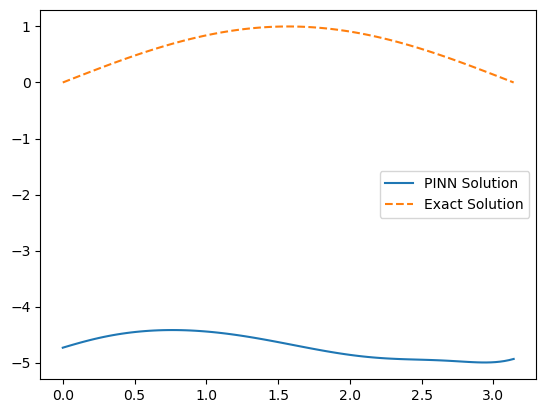

In [61]:

x = np.linspace(0, torch.pi, 100).reshape(-1, 1)
t = np.zeros(100).reshape(-1, 1)

y = np.sin(x)

u = model.predict(x, t)
plt.plot(x, u, label="PINN Solution")
plt.plot(x, y, label="Exact Solution", linestyle="dashed")
plt.legend()

In [80]:
nodes = 64
layers = [2, nodes, nodes, nodes, nodes, 2]

model = PINN(x_d, t_d, layers, fun, vec1, vec2)

In [81]:
state_dict = torch.load("time_model_weights.pth", map_location=torch.device("cpu"), weights_only=True)
model.dnn.load_state_dict(state_dict)

<All keys matched successfully>

In [82]:
# Define the resolution of the grid
x_min, x_max = 0, np.pi  # X range
t_min, t_max = 0, 1  # Time range
grid_size = 100  # Number of points in each dimension

# Create a meshgrid
x_vals = np.linspace(x_min, x_max, grid_size)
t_vals = np.linspace(t_min, t_max, grid_size)
X, T = np.meshgrid(x_vals, t_vals)  # Create a 2D meshgrid

# Flatten the meshgrid and convert to PyTorch tensor
X_flat = X.flatten().reshape(-1, 1)
T_flat = T.flatten().reshape(-1, 1)

u_exact = np.sin(X_flat) * np.cos(4 * torch.pi * T_flat)
u_pred = model.predict(X_flat, T_flat)

abs_error = np.abs(u_pred - u_exact)
l2_error = np.linalg.norm(u_pred - u_exact) / np.linalg.norm(u_exact, 2)

u_pred = u_pred.reshape(grid_size, grid_size)
u_exact = u_exact.reshape(grid_size, grid_size)
abs_error = abs_error.reshape(grid_size, grid_size)

print(l2_error)

0.2535648704224431


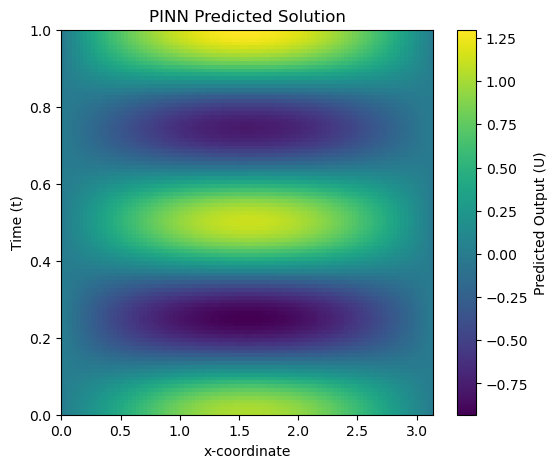

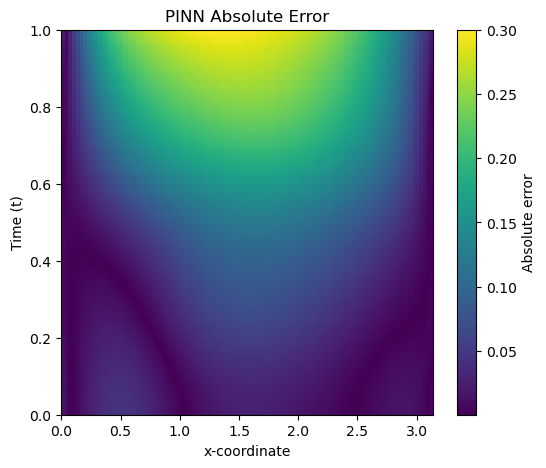

In [83]:

plt.figure(figsize=(6, 5))
plt.imshow(u_pred, extent=[x_min, x_max, t_min, t_max], origin="lower", aspect="auto")
plt.colorbar(label="Predicted Output (U)")
plt.xlabel("x-coordinate")
plt.ylabel("Time (t)")
plt.title("PINN Predicted Solution")


plt.figure(figsize=(6, 5))
plt.imshow(abs_error, extent=[x_min, x_max, t_min, t_max], origin="lower", aspect="auto")
plt.colorbar(label="Absolute error")
plt.xlabel("x-coordinate")
plt.ylabel("Time (t)")
plt.title("PINN Absolute Error")

plt.show()